# Final Project: Sunspots Monthly Average
File: Sunspots.csv

This dataset contains historical records of sunspots. Typical sunspot datasets include measurements such as the date of observation, sunspot numbers, and sometimes details about solar cycles. Such data is crucial for studying solar activity and its cycles over time.

Sunspots are classified as areas where the magnetic field is about 2500 times stronger than Earth's.

## 1.0 Preparing Jupyter Notebook

### Package Downloads

In [6]:
#Import necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings

### Jupyter Notebook Settings

In [7]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns',100)

### Function Creation

In [8]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [9]:
#Create a scatterplot graph
def scatter(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(14,6))
    plt.scatter(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [10]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
#Create a rolling mean of the data to understand the trend

def roll_mean(df_column,window,title,xlabel,ylabel):

    plt.figure(figsize=(10,6))
    rolmean = df_column.rolling(window).mean()

    # Plot the original data and the rolling mean
    plt.figure(figsize=(10, 6))
    plt.plot(df_column, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean (window={window})')

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend and display plot
    plt.legend(loc='best')
    plt.show()

In [12]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

In [13]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.plot(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [14]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [15]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [16]:
from pmdarima import auto_arima

def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

## 1.1 Data Preprocessing:
Load the dataset and convert the date information into a datetime object to facilitate time series analysis.
Check for missing values and anomalies, and handle them appropriately.

### Import Data

In [17]:
#Import the data using pandas
sunspots = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Applied Statistics & Modeling/Final Project/Data Files/Sunspots.csv')
sunspots

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8


### Preprocess dataframe

In [18]:
#First drop the unecessary columns
sunspots_cleaned = sunspots.copy()
sunspots_cleaned.drop(columns='Unnamed: 0',inplace=True)

In [19]:
#Rename column 'Monthly Mean Total Sunspot Number' to 'Monthly Mean'
sunspots_cleaned.rename(columns={'Monthly Mean Total Sunspot Number': 'Monthly Mean'}, inplace=True)

In [20]:
#Convert date to datetime then make it so that values are the first of every month rather than the last
sunspots_cleaned['Date'] = pd.to_datetime(sunspots_cleaned['Date'])
sunspots_cleaned['Date']= sunspots_cleaned['Date'] - pd.offsets.MonthBegin(1)

In [21]:
#Set the index to be the date column
sunspots_cleaned.set_index('Date',inplace=True)
sunspots_cleaned

,Monthly Mean
Date,
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7
...,...
2020-09-01,0.6
2020-10-01,14.4
2020-11-01,34.0


In [22]:
#Double check the columns are in the right format
#Expect '<M8[ns]' for index
#Expect 'float64' or 'int64' for monthly mean
print('Date dtype: ',sunspots_cleaned.index.dtype)
print('')
print('Monthly Mean dtype: ',sunspots_cleaned['Monthly Mean'].dtype)

Date dtype:  datetime64[ns]

Monthly Mean dtype:  float64


### Check for Missing Values

In [23]:
#Use isna is to create a series of true and false
#sum those to get a total number of missing values
#if it is 0 you can continue
sunspots_cleaned['Monthly Mean'].isna().sum()

0

### Check for Anomalies
There are a number of ways to do this. I am going to use the statistical way by creating z scores and see if any of them lie outside of this

In [24]:
#Create zscore value
sunspots_cleaned['zscore'] = (sunspots_cleaned['Monthly Mean'] - sunspots_cleaned['Monthly Mean'].mean()) / sunspots_cleaned['Monthly Mean'].std()

#Identify anomalies where their standard deviation is greater than 3
anomalies = sunspots_cleaned[abs(sunspots_cleaned['zscore']) > 3]

if len(anomalies) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected:")
    print(anomalies)

Anomalies detected:
            Monthly Mean    zscore
Date                              
1778-01-01         295.5  3.148085
1778-05-01         398.2  4.660842
1778-06-01         286.0  3.008151
1778-09-01         286.2  3.011097
1787-12-01         290.0  3.067071
1836-12-01         343.8  3.859538
1837-01-01         313.4  3.411750
1837-02-01         292.6  3.105369
1847-10-01         300.6  3.223207
1849-01-01         298.3  3.189329
1870-05-01         293.6  3.120098
1957-09-01         334.0  3.715185
1957-10-01         359.4  4.089324
1957-11-01         298.6  3.193748
1957-12-01         339.0  3.788834
1958-01-01         286.7  3.018462
1959-01-01         307.7  3.327790


Text(0, 0.5, 'Average Monthly Value')

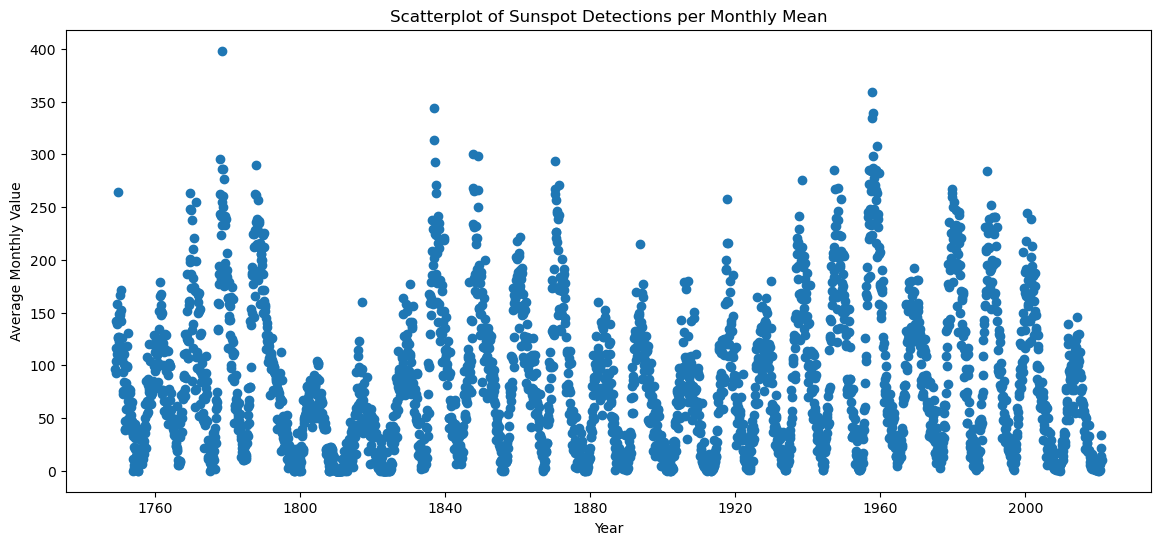

In [25]:
#Plot the data to see how much these values actually influence the data
plt.figure(figsize=(14,6))
plt.scatter(sunspots_cleaned.index,sunspots_cleaned['Monthly Mean'])
plt.title('Scatterplot of Sunspot Detections per Monthly Mean')
plt.xlabel('Year')
plt.ylabel('Average Monthly Value')

From the scatterplot you can see that a majority of these anomalies work with the movement. The anomalies that do exist will only need to be removed when looking at the trend. So I will create a new dataframe that removes these rows. However overall there is no need to remove any of the anomalies.

In [26]:
#Drop the anomalies indexes from the df from above
#Label it as trend as this is the only time that this data will need to be removed
sunspots_cleaned_trend = sunspots_cleaned.drop(anomalies.index)

## 1.2 Exploratory Data Analysis (EDA):
Visualize the data to understand trends, seasonality, and other characteristics.

Decompose the series to observe its components: trend, seasonality, and residuals.

### Visualise Sunspots Data

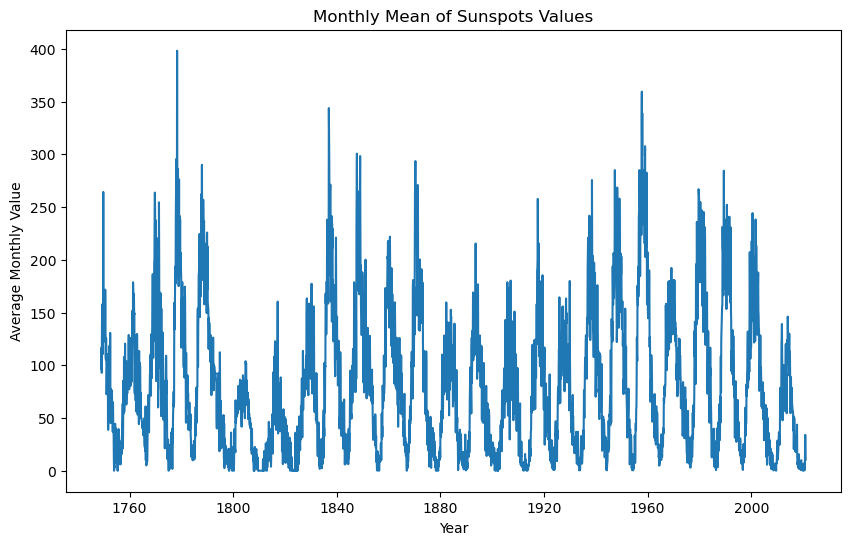

In [27]:
#Create a scatterplot of the data
time_series(sunspots_cleaned.index,sunspots_cleaned['Monthly Mean'],'Monthly Mean of Sunspots Values','Year','Average Monthly Value')

You can observe that there are some clear cycles that take place across certain time periods. These values will also drop back down to zero during certain times. There does not seem to be a massive trend movement, this will be explored more in the seasonal decomposition

### Exploration of Seasonal Decomposition of Sunspots Data 

#### Seasonality Period Decision
There is no given seasonality so there are 2 methods that I am going to use to determine the seasonal period
1. Visualisation
2. ACF & PACF Plots

##### 1. Visualisation Review of Seasonality Period Decision
Look at the rolling mean to reduce the impact of irregularities and to look at overall trends, this can be done by removing the anomalies from before as well as taking a rolling average of 12.

<Figure size 1000x600 with 0 Axes>

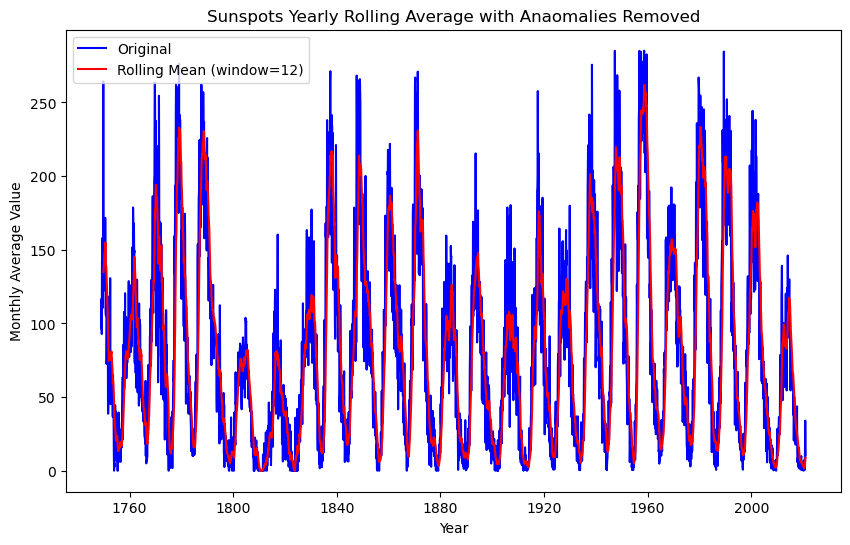

In [28]:
roll_mean(sunspots_cleaned_trend['Monthly Mean'],12,'Sunspots Yearly Rolling Average with Anaomalies Removed','Year','Monthly Average Value')

This is difficult to read, zoom into a 40 year period from 1960 to 2000 as the data seems quite smooth there.

<Figure size 1000x600 with 0 Axes>

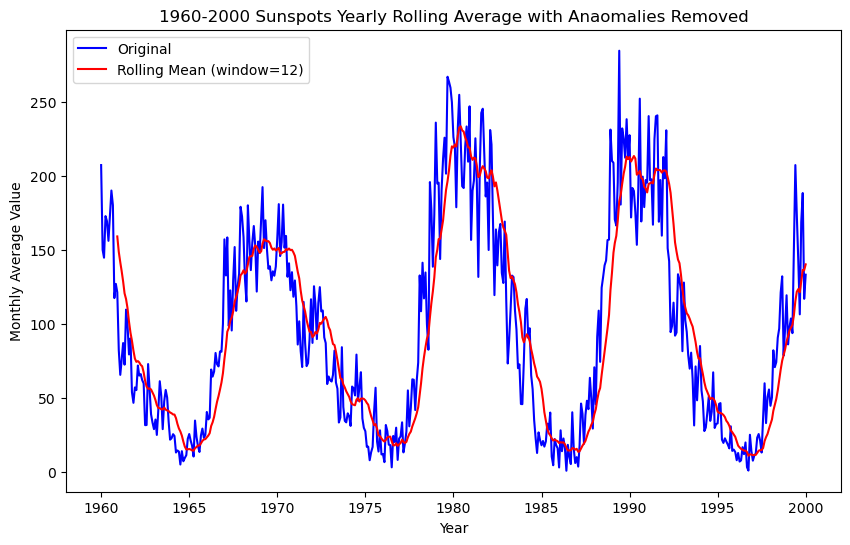

In [29]:
sunspots_cleaned_trend_time_period_1 = pd.DataFrame(sunspots_cleaned_trend['Monthly Mean'].loc['1960-01-01':'2000-01-01'])
roll_mean(sunspots_cleaned_trend_time_period_1['Monthly Mean'],12,'1960-2000 Sunspots Yearly Rolling Average with Anaomalies Removed','Year','Monthly Average Value')

It seems to be that every 10 years there is a fluctuation where the maximum values happen around the turn of the decade. I am going to use 120 as the period as this is 10 years of 12 values per year (monthly recordings)

##### 2. ACF & PACF Plots
Looking at the ACF and PACF plots is going to give insight for different things

1. ACF plot - Is looking at the moving average nature of the graph, this is how much values from lag k-1 impact lag k.

2. PACF plot - Is looking at the autoregressive nature of the graph, this is how values from lag k impact the current value

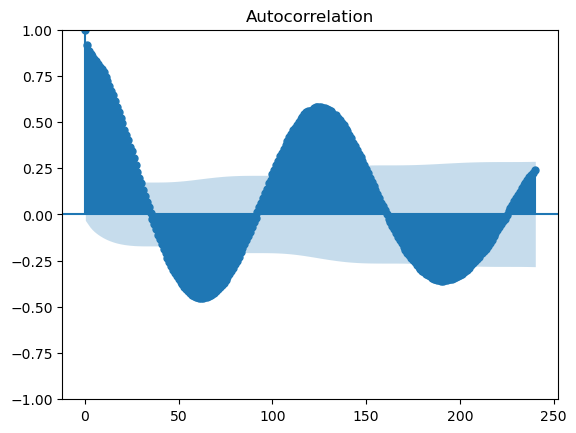

In [30]:
#Look at the acf plot to determine the moving average (trend)
sunspots_cleaned_trend_acf = plot_acf(sunspots_cleaned_trend['Monthly Mean'],lags=240)

This only shows that there is a decreaing autocorrelation as time continues but does not show any further detail.

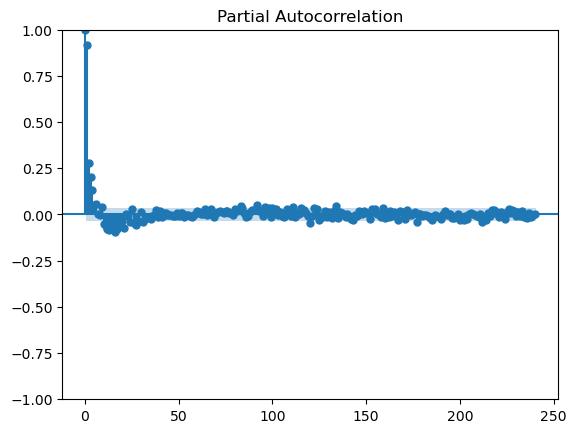

In [31]:
#Look at the PACF plot to determine the autoregressive nature (seasonality)
sunspots_cleaned_trend_pacf = plot_pacf(sunspots_cleaned_trend['Monthly Mean'],lags=240)

The PACF values do not show any lag values which should be looked at specifically. The ACF and PACF values do not show as useful information as the visualisation of data from 1960 to 2000. I am going to look at period values between 9 and 11 years.

#### Seasonal Decomposition of Different Periods
Looking at the different seasonal decompositions ranging from years 9 to 12 is going to help determine the most accurate model. This is an important step as it sets up the analysis for the rest of the project. 

##### Seasonal Decomposition - Period of 9 years

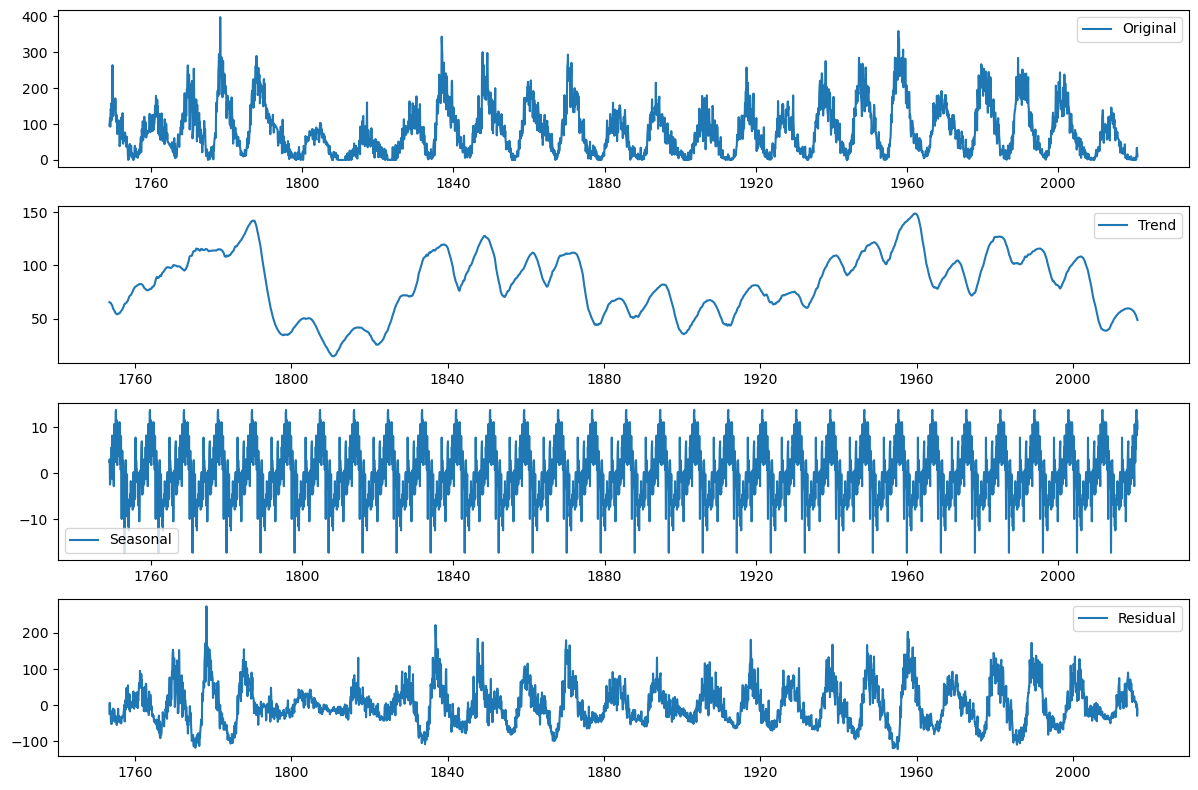

In [32]:
#plot the seasonal decomposition where the period is 9 years long
plot_seasonal_decomposition(sunspots_cleaned['Monthly Mean'],(12*9))

In [33]:
#Find the mean absolute error of nine year period 
nine_year_sunspot_decomposition = decompose_seasonality(sunspots_cleaned['Monthly Mean'],(12*9))
nine_year_sunspot_decomposition_residual = nine_year_sunspot_decomposition[3]
nine_year_sunspot_decomposition_residual.dropna(inplace=True)
zeros = np.zeros(len(nine_year_sunspot_decomposition_residual))
mean_absolute_error(zeros, nine_year_sunspot_decomposition_residual)

43.1113434310481

##### Seasonal Decomposition - Period of 10 years

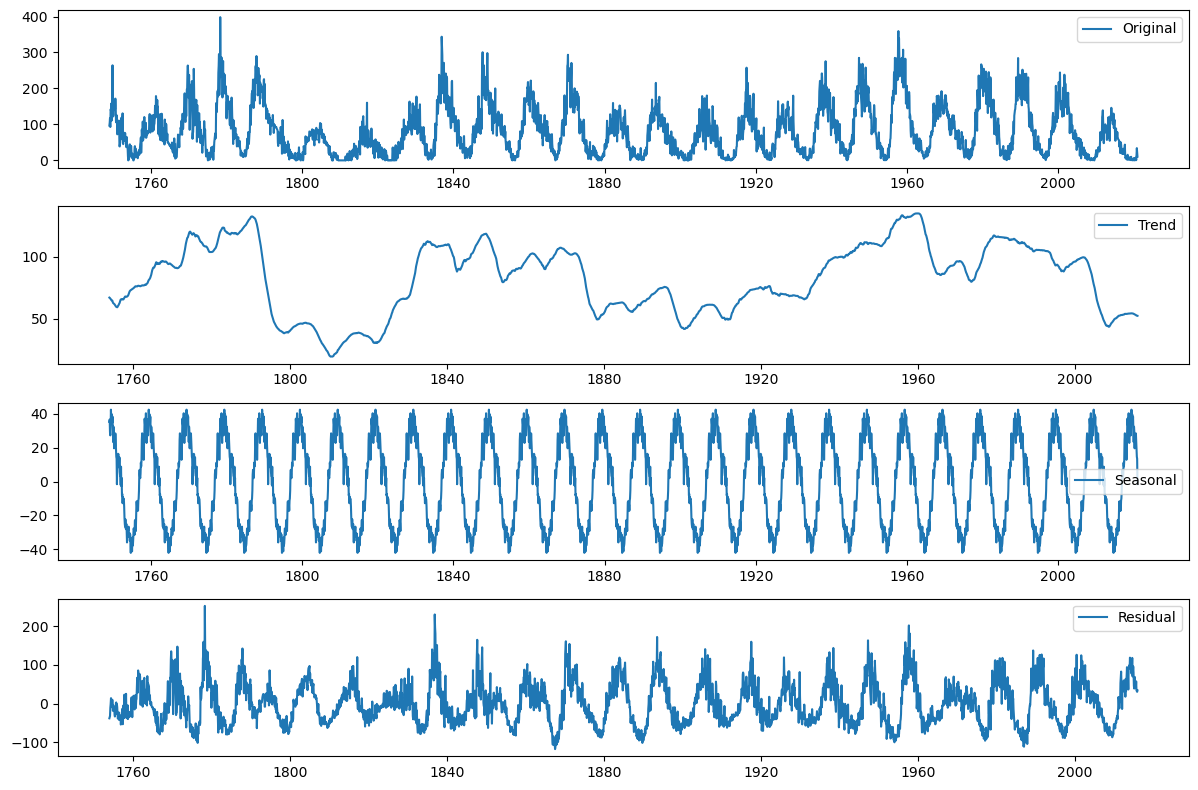

In [34]:
#plot the seasonal decomposition where the period is 10 years long
plot_seasonal_decomposition(sunspots_cleaned['Monthly Mean'],(12*10))

In [35]:
#Find the mean absolute error of ten year period 
ten_year_sunspot_decomposition = decompose_seasonality(sunspots_cleaned['Monthly Mean'],(12*10))
ten_year_sunspot_decomposition_residual = ten_year_sunspot_decomposition[3]
ten_year_sunspot_decomposition_residual.dropna(inplace=True)
zeros_2 = np.zeros(len(ten_year_sunspot_decomposition_residual))
mean_absolute_error(zeros_2, ten_year_sunspot_decomposition_residual)

44.05606900747373

##### Seasonal Decomposition - Period of 11 years

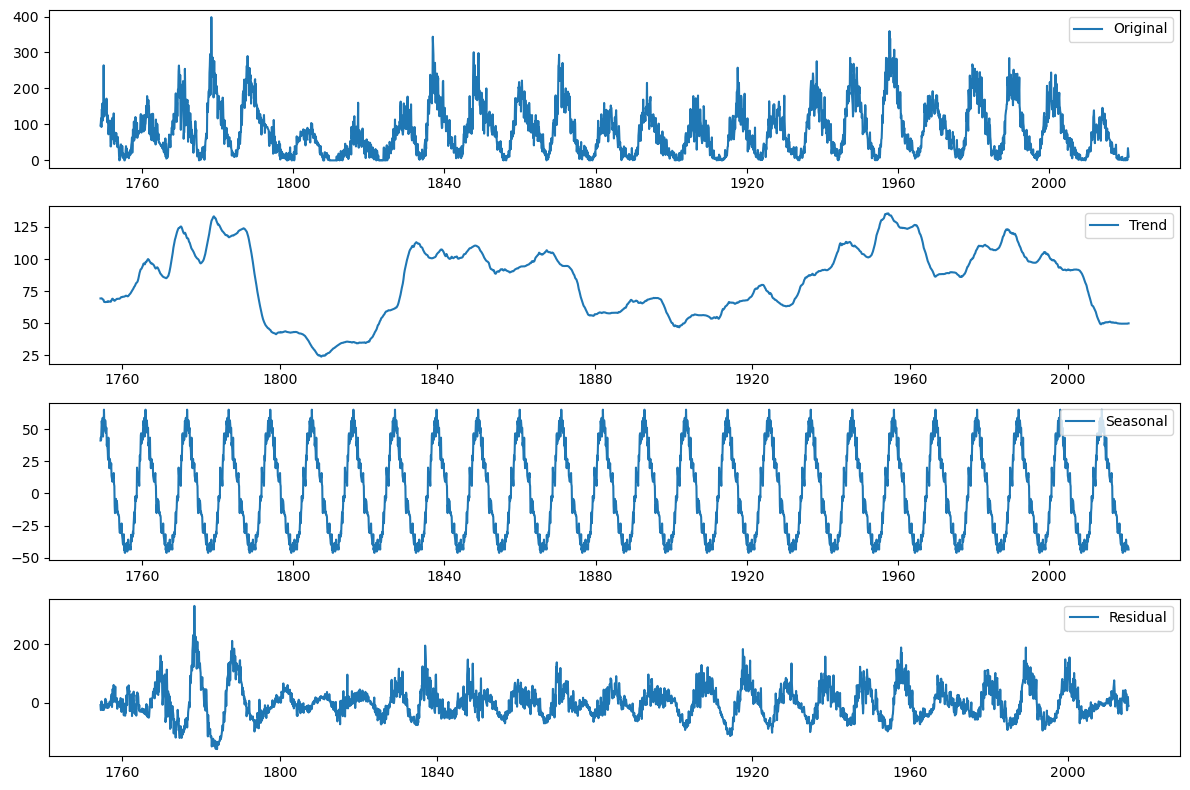

In [36]:
#plot the seasonal decomposition where the period is 11 years long
plot_seasonal_decomposition(sunspots_cleaned['Monthly Mean'],(132))

In [37]:
#Find the mean absolute error of eleven year period 
eleven_year_sunspot_decomposition = decompose_seasonality(sunspots_cleaned['Monthly Mean'],(12*11))
eleven_year_sunspot_decomposition_residual = eleven_year_sunspot_decomposition[3]
eleven_year_sunspot_decomposition_residual.dropna(inplace=True)
zeros_3 = np.zeros(len(eleven_year_sunspot_decomposition_residual))
mean_absolute_error(zeros_3, eleven_year_sunspot_decomposition_residual)

41.34308950683846

##### Seasonal Decomposition - Period of 12 Years

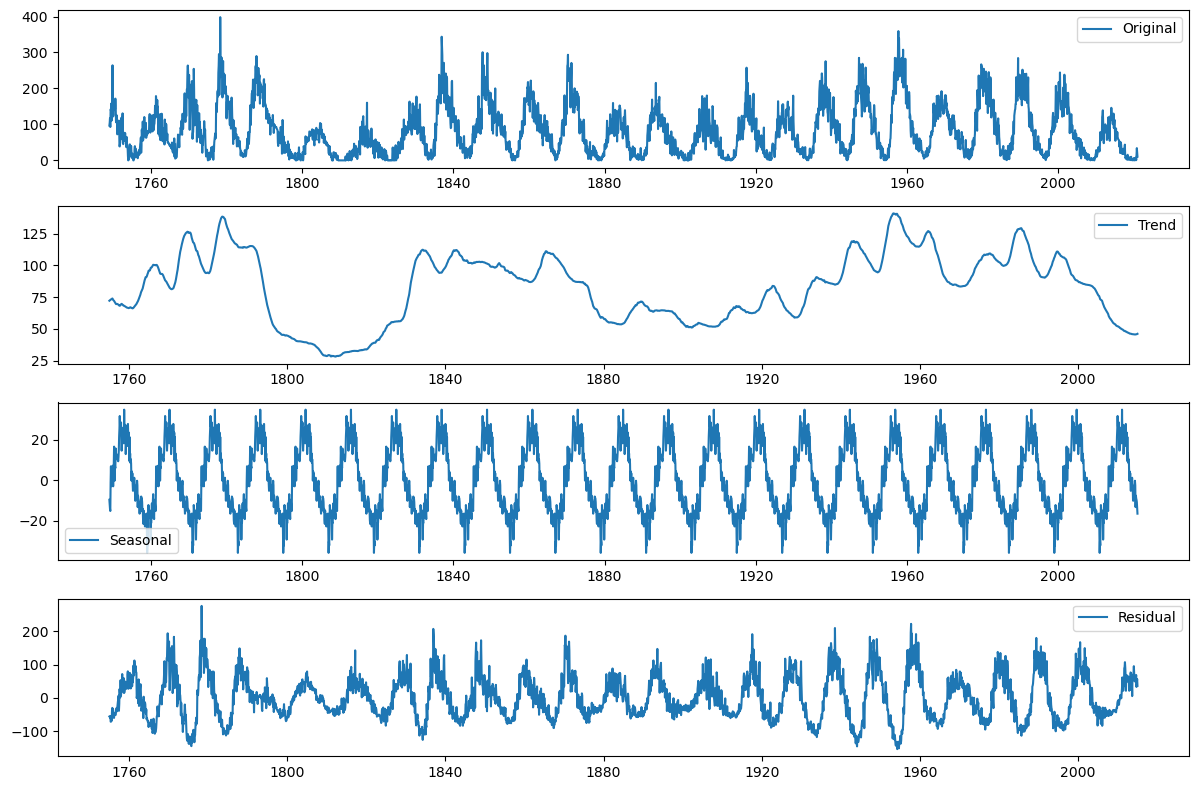

In [38]:
#plot the seasonal decomposition where the period is 12 years long
plot_seasonal_decomposition(sunspots_cleaned['Monthly Mean'],(144))

In [39]:
#Find the mean absolute error of twelve year period 
twelve_year_sunspot_decomposition = decompose_seasonality(sunspots_cleaned['Monthly Mean'],(12*12))
twelve_year_sunspot_decomposition_residual = twelve_year_sunspot_decomposition[3]
twelve_year_sunspot_decomposition_residual.dropna(inplace=True)
zeros_4 = np.zeros(len(twelve_year_sunspot_decomposition_residual))
mean_absolute_error(zeros_4, twelve_year_sunspot_decomposition_residual)

53.81079465932563

##### Seasonal Period Selection
The best seasonality is going to be 11 years (132 data values). This has the lowest residual as well as the smallest residual pattern. The seasonal decomposition can now take place for year 11.

### Seasonal Decomposition of Sunspots
Using a period of 11 years, break down the data into its individual components to understand how the data moves over time

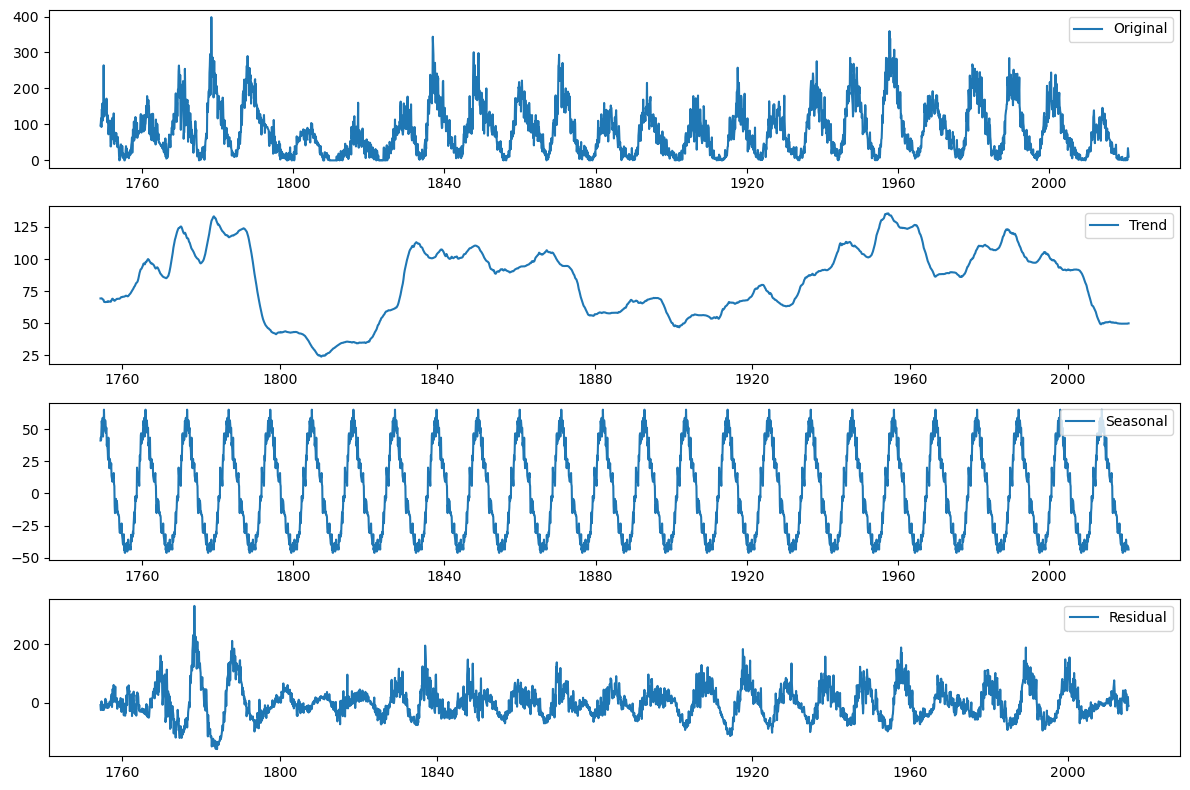

In [40]:
#Create a variable which can be referrenced to get each of the different series
#Plot the decomposition with a period of 132 months (11 years)
sunspots_seasonal_decomposition = decompose_seasonality(sunspots_cleaned['Monthly Mean'],132)
plot_seasonal_decomposition(sunspots_cleaned['Monthly Mean'],(132))

#### Trend of Sunspots

In [41]:
#Create an incrementing months column so that a line of best fit can go through the data
sunspots_cleaned_trend['Incrementing Month'] = range(1,len(sunspots_cleaned_trend) + 1)
sunspots_cleaned['Incrementing Month'] = range(1,len(sunspots_cleaned) + 1)

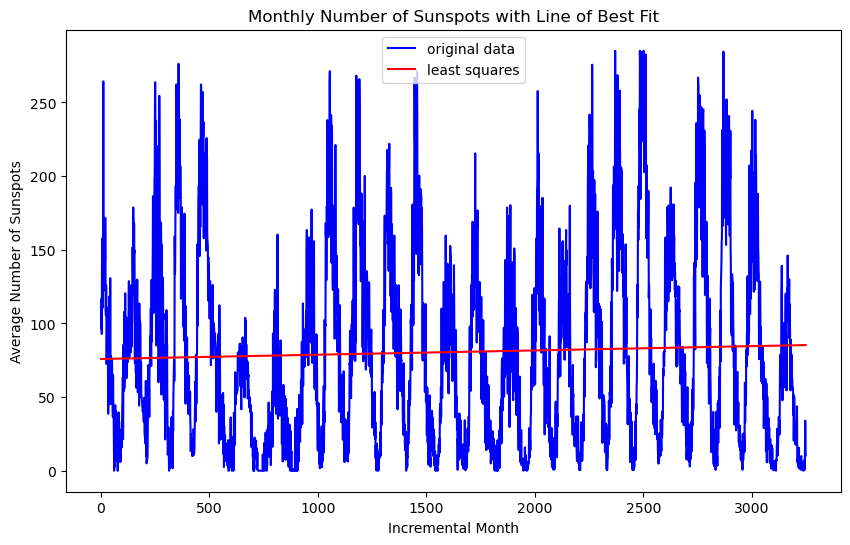

In [42]:
#Plot the original data with the least squares line
plot_least_squares_line(sunspots_cleaned_trend['Incrementing Month'],sunspots_cleaned_trend['Monthly Mean'],'Monthly Number of Sunspots with Line of Best Fit','Incremental Month','Average Number of Sunspots')

In [43]:
#Look at the ADF statistic to determine stationarity
adf_test(sunspots_cleaned['Monthly Mean'])

ADF Statistic:  -10.497051662546138
P-Value:  1.1085524921956742e-18
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


There is an overall constant movement in the data. This is solidified by the ADF statistic being well above the threshold to have a 99% confidence that the graph is stationary. This means that the value of the time series is not dependent on the time.

#### Seasonality of sunspots

In [44]:
#Create a dataframe for 11 years of the seasonality rather than 1750-2020
#This will be 132 monthly values 
#These values can observe how values are expected to change based on their time within the 11 years
sunspots_cleaned_seasonal_values = pd.DataFrame(sunspots_seasonal_decomposition[2].iloc[0:132])
sunspots_cleaned_seasonal_values['Incrementing Month'] = range(1, len(sunspots_cleaned_seasonal_values)+1)
sunspots_cleaned_seasonal_values

,seasonal,Incrementing Month
Date,,
1749-01-01,41.202966,1
1749-02-01,43.634516,2
1749-03-01,41.888019,3
1749-04-01,50.691066,4
1749-05-01,56.499336,5
...,...,...
1759-08-01,33.495485,128
1759-09-01,45.294632,129
1759-10-01,46.859374,130


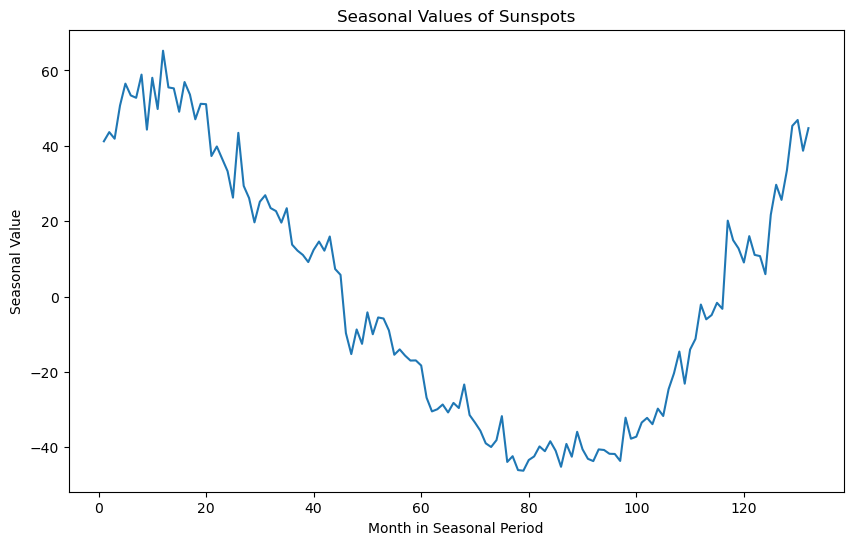

In [45]:
#Plot the seasonal values
time_series(sunspots_cleaned_seasonal_values['Incrementing Month'],sunspots_cleaned_seasonal_values['seasonal'],'Seasonal Values of Sunspots','Month in Seasonal Period','Seasonal Value')

The seasonal pattern shows that there is a spike around the start of the seasonal period with a downturn to about 80-100 months onwards (years 7-8), before returning back to a maximum.

#### Residual of sunspots

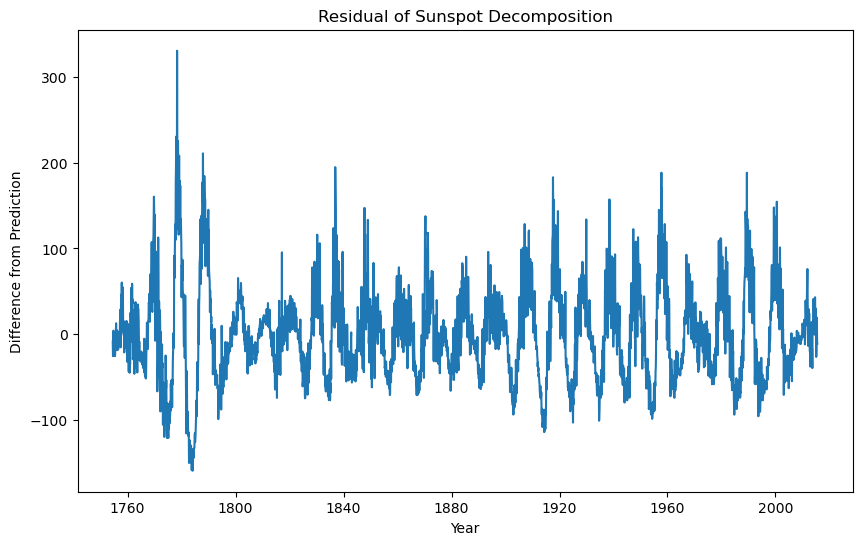

In [46]:
#Plot the residual of sunspots 
time_series(sunspots_seasonal_decomposition[3].index,sunspots_seasonal_decomposition[3],'Residual of Sunspot Decomposition','Year','Difference from Prediction')

As found before the mean absolute error is about 41. From the graph you can see that there is no real clear pattern and it seems to be relative white noise about a mean of 0 which means there isn't any missing component of the data that has not been included.

## 1.3 ARIMA Model Building:
Determine the order of differencing (d) needed to make the series stationary.
Identify the autoregressive term (p) and moving average term (q) using plots such as the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).
Construct and fit the ARIMA model to the historical data.

#### ARIMA Modeling
The following ARIMA modeling types are going to be explored
- AR: Autoregressive Model (p value - using PACF to find order)
- MA: Moving Average Model (q value - using ACF to find order)
- ARMA: Autoregressive Moving Average (p value, q value)
- ARIMA: Autoregressive Integrated Moving Average (p value, d value, q value)
- SARIMA: Seasonal Autoregressive Integrated Moving Average (p value, d value, q value, P value, D value, Q value, seasonal). P value found through seasonal PACF, D value found through seasonal ADF statistic, Q value found through seasonal ACF

#### p,d,q orders value

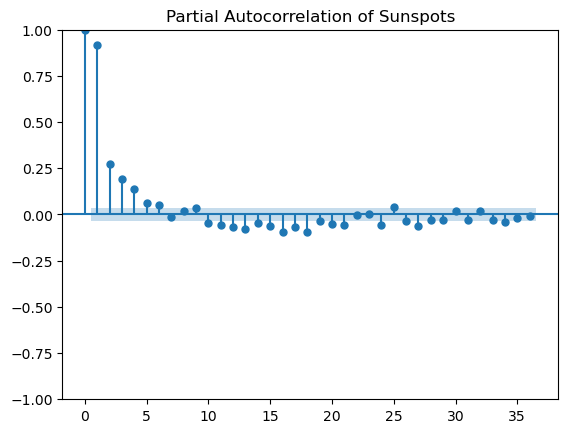

In [47]:
#Use the pacf plot to find the p model
sunsports_cleaned_pacf = plot_pacf(sunspots_cleaned['Monthly Mean'],title='Partial Autocorrelation of Sunspots')

In [48]:
#Create a list of p orders
p_orders_value = [1,2]

In [49]:
#Look at the ADF statistic to determine the d value
adf_test(sunspots_cleaned['Monthly Mean'])

ADF Statistic:  -10.497051662546138
P-Value:  1.1085524921956742e-18
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [50]:
#Create a list of d orders
d_orders_value = [0,1]

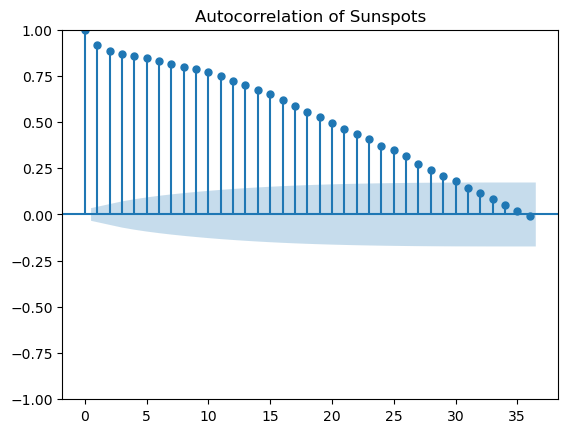

In [51]:
#Look at the ACF plot to find q
sunspots_cleaned_acf = plot_acf(sunspots_cleaned['Monthly Mean'],title='Autocorrelation of Sunspots')

In [52]:
#Create a list of q orders
q_orders_value = [1,2]

#### P,D,Q orders value

In [53]:
#Remove the seasonal values from the cleaned data
sunspots_cleaned_seasonally_adjusted = sunspots_seasonal_decomposition[0] - sunspots_seasonal_decomposition[2]
sunspots_cleaned_seasonally_adjusted

Date
1749-01-01    55.497034
1749-02-01    60.665484
1749-03-01    74.811981
1749-04-01    42.108934
1749-05-01    85.200664
                ...    
2020-09-01    41.133193
2020-10-01    55.089427
2020-11-01    75.692852
2020-12-01    63.546387
2021-01-01    53.990658
Length: 3265, dtype: float64

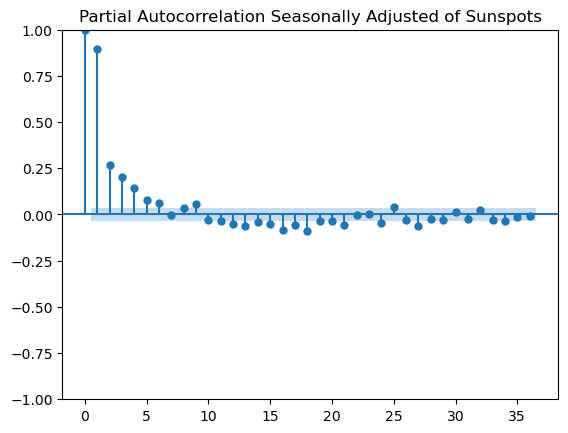

In [54]:
#Use the PACF to find P values
sunspots_cleaned_seasonally_adjusted_pacf = plot_pacf(sunspots_cleaned_seasonally_adjusted,title='Partial Autocorrelation Seasonally Adjusted of Sunspots')

In [55]:
#Create a list of P orders
P_orders_value = [1,2]

In [56]:
#Look at the ADF statistic of the sesonally adjusted value to find D value
adf_test(sunspots_cleaned_seasonally_adjusted)

ADF Statistic:  -9.502626339936468
P-Value:  3.412819308375638e-16
Critical Value: 
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [57]:
#Create a list of D orders
D_orders_value = [0,1]

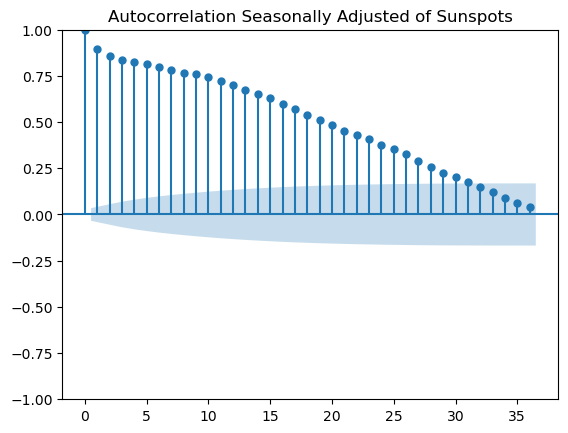

In [58]:
#Use the ACF plot to find Q value
sunspots_cleaned_seasonally_adjusted_acf = plot_acf(sunspots_cleaned_seasonally_adjusted,title='Autocorrelation Seasonally Adjusted of Sunspots')

In [59]:
#Create a list of Q orders
Q_orders_value = [1,2]

After trying to include the P,D,Q and s for the SARIMA model, it would take 5 minutes and there would still not be an answer. Because of this SARIMA model has not been included in the analysis. It was due to the extremely high length of the seasonal period.

#### ARIMA Model Evaluation
Using the function above, there is going to be an ordered list of most effective (using AIC) order for different models.

In [60]:
#Create a list of different ARIMA models to choose 
evaluate_time_series_models(sunspots_cleaned['Monthly Mean'],p_orders_value,q_orders_value,d_orders_value)

,Model,Order,AIC,BIC
15,ARIMA,"(2, 1, 2)",30250.957980,30281.411524
5,ARMA,"(1, 0, 2)",30316.781285,30347.236360
9,ARIMA,"(1, 0, 2)",30316.781285,30347.236360
7,ARMA,"(2, 0, 2)",30318.779675,30355.325766
13,ARIMA,"(2, 0, 2)",30318.779675,30355.325766
6,ARMA,"(2, 0, 1)",30321.223487,30351.678562
12,ARIMA,"(2, 0, 1)",30321.223487,30351.678562
14,ARIMA,"(2, 1, 1)",30329.219256,30353.582091
11,ARIMA,"(1, 1, 2)",30331.183799,30355.546633
10,ARIMA,"(1, 1, 1)",30333.403911,30351.676037


## 1.4 Forecasting:
Forecast the future for what seems reasonable based upon the data.
Plot the predictions against the actual data (if available) to visualize the forecast's accuracy.

In [61]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Step 1: Fit ARIMA model to historical data
model = ARIMA(sunspots_cleaned['Monthly Mean'], order=(2, 1, 2))  # Specify ARIMA(p, d, q) model order
arima_model = model.fit()

# Step 2: Model Diagnostic (optional)
# Perform diagnostics to evaluate model fit
print(arima_model.summary())

# Step 3: Forecasting
# Generate forecasts for future time points
forecast = arima_model.forecast(steps=120)  # Specify the number of steps to forecast

forecast

                               SARIMAX Results                                
Dep. Variable:           Monthly Mean   No. Observations:                 3265
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15120.479
Date:                Tue, 30 Apr 2024   AIC                          30250.958
Time:                        18:42:31   BIC                          30281.412
Sample:                    01-01-1749   HQIC                         30261.865
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3251      0.021     64.184      0.000       1.285       1.366
ar.L2         -0.3768      0.021    -18.102      0.000      -0.418      -0.336
ma.L1         -1.7579      0.014   -128.570      0.0

2021-02-01    12.922901
2021-03-01    14.568040
2021-04-01    15.797285
2021-05-01    16.806204
2021-06-01    17.679895
                ...    
2030-09-01    26.343977
2030-10-01    26.344004
2030-11-01    26.344029
2030-12-01    26.344051
2031-01-01    26.344072
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

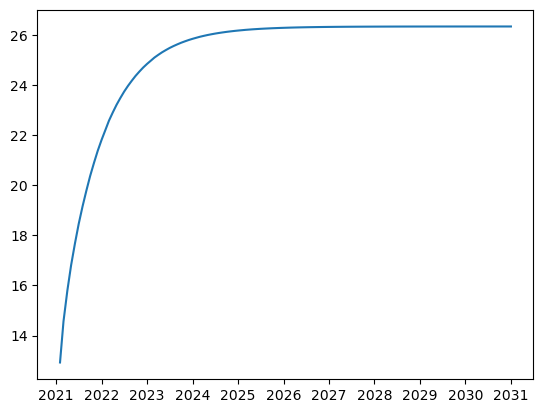

In [62]:
plt.plot(forecast)

## 1.5 Model Evaluation:
Use metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and others to evaluate the model.
Discuss the model's limitations and any discrepancies observed between the predicted and actual values.